<a href="https://colab.research.google.com/github/ChanapatC/Customer-Analytics/blob/main/03_04_Supermarket_ver2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
%pip install pycaret

In [7]:
import pandas as pd
import numpy as np
import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
path = '/content/drive/MyDrive/Colab Notebooks/MADT/MADT8101/Workshop 2/supermarket.csv'



In [10]:
df = pd.read_csv(path)

In [11]:
df = df.fillna(0)


In [12]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578082 entries, 0 to 578081
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SHOP_WEEK                 578082 non-null  int64  
 1   SHOP_DATE                 578082 non-null  int64  
 2   SHOP_WEEKDAY              578082 non-null  int64  
 3   SHOP_HOUR                 578082 non-null  int64  
 4   QUANTITY                  578082 non-null  int64  
 5   SPEND                     578082 non-null  float64
 6   PROD_CODE                 578082 non-null  object 
 7   PROD_CODE_10              578082 non-null  object 
 8   PROD_CODE_20              578082 non-null  object 
 9   PROD_CODE_30              578082 non-null  object 
 10  PROD_CODE_40              578082 non-null  object 
 11  CUST_CODE                 578082 non-null  object 
 12  CUST_PRICE_SENSITIVITY    578082 non-null  object 
 13  CUST_LIFESTAGE            578082 non-null  o

In [13]:
df.describe ()

,SHOP_WEEK,SHOP_DATE,SHOP_WEEKDAY,SHOP_HOUR,QUANTITY,SPEND,BASKET_ID
count,578082.000000,5.780820e+05,578082.000000,578082.000000,578082.000000,578082.000000,5.780820e+05
mean,200704.300985,2.006990e+07,3.990647,15.050588,1.531784,1.933858,9.941060e+14
std,65.332750,7.117973e+03,1.996671,3.666903,1.575491,2.877621,3.290063e+09
min,200607.000000,2.006041e+07,1.000000,8.000000,1.000000,0.010000,9.941001e+14
25%,200639.000000,2.006112e+07,2.000000,12.000000,1.000000,0.770000,9.941033e+14
50%,200715.000000,2.007060e+07,4.000000,15.000000,1.000000,1.240000,9.941061e+14
75%,200743.000000,2.007122e+07,6.000000,18.000000,1.000000,2.110000,9.941089e+14
max,200819.000000,2.008071e+07,7.000000,21.000000,129.000000,476.160000,9.941117e+14


EDA

In [14]:
# Calculate the distinct count of basket_id
distinct_count_basket_id = df['BASKET_ID'].nunique()

# Display the result
print("Distinct count of BASKET_ID:", distinct_count_basket_id)


Distinct count of BASKET_ID: 77234


In [15]:
# Drop the rows with Customer_code = 0
df = df[df['CUST_CODE'] != 0]

# Group by 'user' and calculate the sum of 'spend' for each user
spend_sum_by_user = df.groupby('CUST_CODE', as_index=False)['SPEND'].sum()
print (spend_sum_by_user)

           CUST_CODE    SPEND
0     CUST0000000181     2.44
1     CUST0000000689   328.57
2     CUST0000000998     5.95
3     CUST0000001163    39.74
4     CUST0000001194  2493.83
...              ...      ...
3434  CUST0000999439    43.60
3435  CUST0000999544     6.32
3436  CUST0000999593   453.58
3437  CUST0000999935   444.17
3438  CUST0000999936    17.67

[3439 rows x 2 columns]


In [16]:
# Calculate the ARPU and create a new column 'ARPU' in the DataFrame
spend_sum_by_user['ARPU'] = spend_sum_by_user['SPEND'] / distinct_count_basket_id

# Merge spend_sum_by_user DataFrame back into the original DataFrame using 'CUST_CODE' as the key
df = df.merge(spend_sum_by_user[['CUST_CODE', 'ARPU']], on='CUST_CODE', how='left')

# Display the updated DataFrame
print(df)

        SHOP_WEEK  SHOP_DATE  SHOP_WEEKDAY  SHOP_HOUR  QUANTITY  SPEND  \
0          200734   20071019             6          8         1   9.50   
1          200805   20080328             6         21         1   1.49   
2          200815   20080605             5         15         1   0.70   
3          200642   20061213             4         15         1   2.04   
4          200720   20070713             6         17         1   2.19   
...           ...        ...           ...        ...       ...    ...   
492489     200738   20071116             6         12         1   0.01   
492490     200716   20070612             3         12         1  13.76   
492491     200637   20061109             5         16         1   4.47   
492492     200717   20070624             1         10         1   4.92   
492493     200744   20071229             7         14         1   9.27   

         PROD_CODE PROD_CODE_10 PROD_CODE_20 PROD_CODE_30  ... CUST_LIFESTAGE  \
0       PRD0901335      CL0005

In [17]:
# Compute average spending per customer
average_spending = df.groupby('CUST_CODE')['SPEND'].mean().reset_index()
average_spending.rename(columns={'SPEND': 'average_spending'}, inplace=True)

# Merge the 'average_spending' column with the original DataFrame 'df'
df = df.merge(average_spending, on='CUST_CODE', how='left')



In [18]:
# Compute number of purchases per customer
purchase_count = df.groupby('CUST_CODE')['BASKET_ID'].nunique().reset_index()
purchase_count.rename(columns={'BASKET_ID': 'purchase_count'}, inplace=True)

# Merge the 'purchase_count' column with the original DataFrame 'df'
df = df.merge(purchase_count, on='CUST_CODE', how='left')



In [19]:
# Compute visit frequency per customer
visit_frequency = df.groupby('CUST_CODE')['BASKET_ID'].count().reset_index()
visit_frequency.rename(columns={'BASKET_ID': 'visit_frequency'}, inplace=True)


# Merge the 'visit_frequency' column with the original DataFrame 'df'
df = df.merge(visit_frequency, on='CUST_CODE', how='left')


In [20]:
# Display the updated DataFrame
print(df)

        SHOP_WEEK  SHOP_DATE  SHOP_WEEKDAY  SHOP_HOUR  QUANTITY  SPEND  \
0          200734   20071019             6          8         1   9.50   
1          200805   20080328             6         21         1   1.49   
2          200815   20080605             5         15         1   0.70   
3          200642   20061213             4         15         1   2.04   
4          200720   20070713             6         17         1   2.19   
...           ...        ...           ...        ...       ...    ...   
492489     200738   20071116             6         12         1   0.01   
492490     200716   20070612             3         12         1  13.76   
492491     200637   20061109             5         16         1   4.47   
492492     200717   20070624             1         10         1   4.92   
492493     200744   20071229             7         14         1   9.27   

         PROD_CODE PROD_CODE_10 PROD_CODE_20 PROD_CODE_30  ...  \
0       PRD0901335      CL00058     DEP00016 

Delete unnecessary features

In [21]:

# Define the columns to be deleted
columns_to_delete = ['SHOP_WEEK', 'SHOP_WEEKDAY', 'SHOP_HOUR','PROD_CODE_10','PROD_CODE_20','PROD_CODE_30',
                     'PROD_CODE_40','CUST_PRICE_SENSITIVITY','CUST_LIFESTAGE','BASKET_SIZE','BASKET_PRICE_SENSITIVITY',
                     'BASKET_TYPE','STORE_CODE','STORE_FORMAT','STORE_REGION']



# Drop the specified columns
df = df.drop(columns=columns_to_delete)



In [22]:
columns_to_delete2 = ['BASKET_ID']

# Drop the specified columns2
df_new = df.drop(columns=columns_to_delete2)

In [23]:

# Verify the resulting DataFrame
print(df)

        SHOP_DATE  QUANTITY  SPEND   PROD_CODE       CUST_CODE  \
0        20071019         1   9.50  PRD0901335  CUST0000804514   
1        20080328         1   1.49  PRD0901120  CUST0000735558   
2        20080605         1   0.70  PRD0904509  CUST0000138092   
3        20061213         1   2.04  PRD0904730  CUST0000099658   
4        20070713         1   2.19  PRD0900777  CUST0000673735   
...           ...       ...    ...         ...             ...   
492489   20071116         1   0.01  PRD0903678  CUST0000451458   
492490   20070612         1  13.76  PRD0902312  CUST0000957158   
492491   20061109         1   4.47  PRD0900396  CUST0000111024   
492492   20070624         1   4.92  PRD0903065  CUST0000412413   
492493   20071229         1   9.27  PRD0901923  CUST0000509062   

              BASKET_ID BASKET_DOMINANT_MISSION      ARPU  average_spending  \
0       994108000679877                   Fresh  0.000262          3.371667   
1       994110300629787                   Fresh  

In [24]:

# Drop rows where 'CUST_CODE' is null
df = df.dropna(subset=['CUST_CODE'])
df = df.dropna(subset=['ARPU'])

In [25]:

# Check for null values in each column
null_counts = df.isnull().sum()

# Display the null counts for each column
print(null_counts)

SHOP_DATE                  0
QUANTITY                   0
SPEND                      0
PROD_CODE                  0
CUST_CODE                  0
BASKET_ID                  0
BASKET_DOMINANT_MISSION    0
ARPU                       0
average_spending           0
purchase_count             0
visit_frequency            0
dtype: int64


Model

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

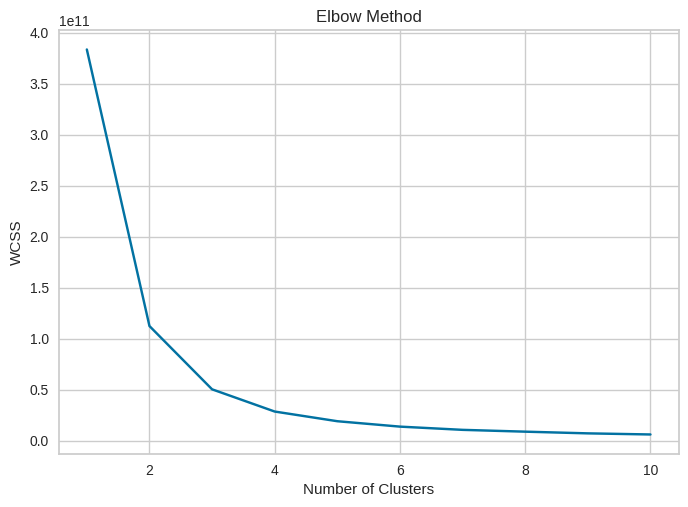

In [26]:
# Select the columns for clustering
cluster_cols = ['ARPU', 'average_spending', 'purchase_count', 'visit_frequency']

# Create a subset of the dataset with the selected columns
df_cluster = df_new[cluster_cols]

# Perform K-means clustering with different numbers of clusters
wcss = []
max_clusters = 10  # Maximum number of clusters to try

for n_clusters in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(df_cluster)
    wcss.append(kmeans.inertia_)

# Plot the within-cluster sum of squares (WCSS) against the number of clusters
plt.plot(range(1, max_clusters + 1), wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


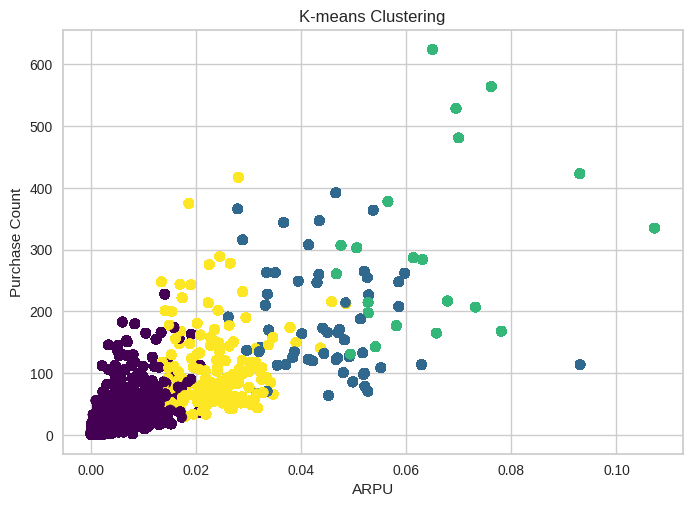

In [27]:
# Select the columns for clustering
cluster_cols = ['ARPU', 'average_spending', 'purchase_count', 'visit_frequency']

# Create a subset of the dataset with the selected columns
df_cluster = df_new[cluster_cols]

# Perform K-means clustering with the optimal number of clusters
k = 4  # Number of clusters
kmeans = KMeans(n_clusters=k)
kmeans.fit(df_cluster)

# Add the cluster labels to the dataset
df_new['cluster'] = kmeans.labels_

# Plot the clusters
plt.scatter(df_new['ARPU'], df_new['purchase_count'], c=df_new['cluster'], cmap='viridis')
plt.xlabel('ARPU')
plt.ylabel('Purchase Count')
plt.title('K-means Clustering')
plt.show()

In [28]:
print (df_new)

        SHOP_DATE  QUANTITY  SPEND   PROD_CODE       CUST_CODE  \
0        20071019         1   9.50  PRD0901335  CUST0000804514   
1        20080328         1   1.49  PRD0901120  CUST0000735558   
2        20080605         1   0.70  PRD0904509  CUST0000138092   
3        20061213         1   2.04  PRD0904730  CUST0000099658   
4        20070713         1   2.19  PRD0900777  CUST0000673735   
...           ...       ...    ...         ...             ...   
492489   20071116         1   0.01  PRD0903678  CUST0000451458   
492490   20070612         1  13.76  PRD0902312  CUST0000957158   
492491   20061109         1   4.47  PRD0900396  CUST0000111024   
492492   20070624         1   4.92  PRD0903065  CUST0000412413   
492493   20071229         1   9.27  PRD0901923  CUST0000509062   

       BASKET_DOMINANT_MISSION      ARPU  average_spending  purchase_count  \
0                        Fresh  0.000262          3.371667               1   
1                        Fresh  0.000159          3

In [29]:

# Define the columns for which you want to calculate the statistics
columns_of_interest = ['ARPU', 'purchase_count','visit_frequency']

# Calculate the mean, minimum, and maximum values for the specified columns in each cluster
cluster_stats = df_new.groupby('cluster')[columns_of_interest].agg(['mean', 'min', 'max'])
cluster_stats_mean = df_new.groupby('cluster')[columns_of_interest].agg(['mean'])

# Display the cluster statistics
cluster_stats = cluster_stats.round(0)
cluster_stats_mean = cluster_stats_mean.round(0)
print(cluster_stats)

# Calculate the mean values for each variable within each cluster
cluster_profiles = df_new.groupby('cluster').mean()

print('_______________________________________________________________________')

# Filter the cluster profiles to include only integer columns
cluster_profiles = cluster_profiles.round(1)

# Display the integer cluster profiles
print(cluster_profiles)


        ARPU           purchase_count           visit_frequency            
        mean  min  max           mean  min  max            mean   min   max
cluster                                                                    
0        0.0  0.0  0.0           37.0    1  228           252.0     1   633
1        0.0  0.0  0.0          185.0   64  392          1792.0  1414  2254
2        0.0  0.0  0.0          314.0  131  624          2788.0  2352  3453
3        0.0  0.0  0.0          113.0   30  417          1012.0   622  1398
_______________________________________________________________________
          SHOP_DATE  QUANTITY  SPEND  ARPU  average_spending  purchase_count  \
cluster                                                                        
0        20069781.7       1.5    2.0   0.0               2.0            37.0   
1        20069777.8       1.6    1.9   0.0               1.9           184.5   
2        20069992.8       1.5    1.8   0.1               1.8           313.8

<ipython-input-29-d517d5925fb4>:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_profiles = df_new.groupby('cluster').mean()


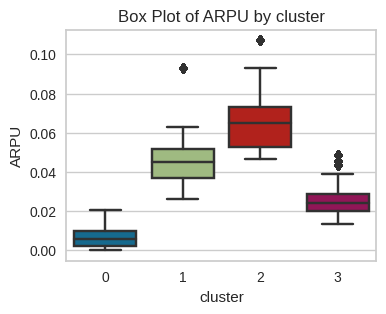

        ARPU purchase_count visit_frequency
        mean           mean            mean
cluster                                    
0        0.0           37.0           252.0
1        0.0          185.0          1792.0
2        0.0          314.0          2788.0
3        0.0          113.0          1012.0


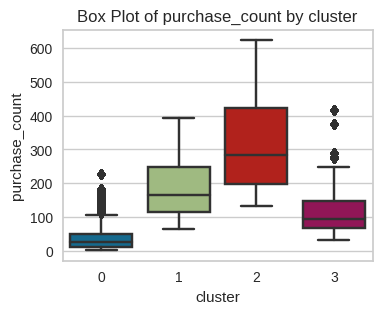

        ARPU purchase_count visit_frequency
        mean           mean            mean
cluster                                    
0        0.0           37.0           252.0
1        0.0          185.0          1792.0
2        0.0          314.0          2788.0
3        0.0          113.0          1012.0


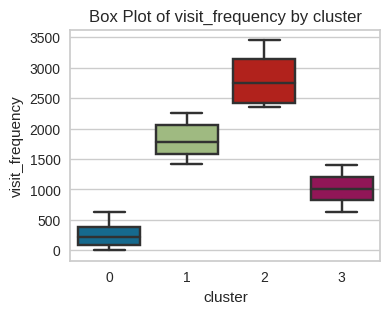

        ARPU purchase_count visit_frequency
        mean           mean            mean
cluster                                    
0        0.0           37.0           252.0
1        0.0          185.0          1792.0
2        0.0          314.0          2788.0
3        0.0          113.0          1012.0


In [30]:


# Create box plots for each column in each cluster
for column in columns_of_interest:
    plt.figure(figsize=(4, 3))
    sns.boxplot(x='cluster', y=column, data=df_new)
    plt.title(f'Box Plot of {column} by cluster')
    plt.xlabel('cluster')
    plt.ylabel(column)
    plt.show()
    print(cluster_stats_mean)

In [31]:
sku_count = df_new.groupby('cluster')['CUST_CODE'].nunique()
print(sku_count)

cluster
0    3213
1      57
2      21
3     148
Name: CUST_CODE, dtype: int64


# Analytics

In [39]:
df['SHOP_DATE'] = pd.to_datetime(df['SHOP_DATE'], format='%Y%m%d')
df['SHOP_DATE'].head()

0   2007-10-19
1   2008-03-28
2   2008-06-05
3   2006-12-13
4   2007-07-13
Name: SHOP_DATE, dtype: datetime64[ns]

In [40]:
# create new df which nan valuues in CUST_CODE
df_non_member = df[df['CUST_CODE'].isna()]
df_non_member.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   SHOP_DATE                0 non-null      datetime64[ns]
 1   QUANTITY                 0 non-null      int64         
 2   SPEND                    0 non-null      float64       
 3   PROD_CODE                0 non-null      object        
 4   CUST_CODE                0 non-null      object        
 5   BASKET_ID                0 non-null      int64         
 6   BASKET_DOMINANT_MISSION  0 non-null      object        
 7   ARPU                     0 non-null      float64       
 8   average_spending         0 non-null      float64       
 9   purchase_count           0 non-null      int64         
 10  visit_frequency          0 non-null      int64         
dtypes: datetime64[ns](1), float64(3), int64(4), object(3)
memory usage: 0.0+ bytes


### non-member sum spending

In [41]:
# non member's average spending group by df_non_member['BASKET_ID']
df_non_member.groupby('BASKET_ID')['SPEND'].mean()


Series([], Name: SPEND, dtype: float64)

In [42]:
# non member's average speding per basket
df_non_member.groupby('BASKET_ID')['SPEND'].mean().mean()


nan

# member

In [ ]:
df_member = df[df['CUST_CODE'].notna()]
df_member.head()


In [ ]:
df_member['SPEND'].sum()

In [ ]:
df_member.groupby('BASKET_ID')['SPEND'].mean().mean()


In [ ]:
df_member["BASKET_ID"].nunique()

In [ ]:
df_non_member["BASKET_ID"].nunique()

In [ ]:
sum_basket_id = df_member["BASKET_ID"].nunique() + df_non_member["BASKET_ID"].nunique()
print(f"unique basket id:",sum_basket_id)

sum_NMB_BASKET_ID = df_non_member["BASKET_ID"].nunique()
print(f"sum non member basket id:",sum_NMB_BASKET_ID)
print(f"non member basket id percentage:",sum_NMB_BASKET_ID/sum_basket_id*100,"%")

sum_MB_BASKET_ID = df_member["BASKET_ID"].nunique()
print(f"sum member basket id:",sum_MB_BASKET_ID)
print(f"member basket id percentage:",sum_MB_BASKET_ID/sum_basket_id*100,"%")



# first item purchase

In [ ]:
# df_member sort by SHOP_DATE
df_member.sort_values(by=['SHOP_DATE'], inplace=True)
df_member.head()

In [ ]:
df_item = df_member[['SHOP_DATE', 'QUANTITY', 'CUST_CODE', 'PROD_CODE', 'PROD_CODE_10']]
df_item.info()

In [ ]:
# df_item filter only first shop_date for each customer
df_item_first = df_item.groupby('CUST_CODE')['SHOP_DATE'].min().reset_index()
df_item_first.info()


In [ ]:
df_item_first

In [ ]:
# filter other columns in df_item_first
df_item_first_fill = df_item.merge(df_item_first, on=['CUST_CODE', 'SHOP_DATE'], how='inner')
df_item_first_fill.info()



In [ ]:
df_item_first_fill.head(10)

In [ ]:
tep5_item = df_item_first_fill['PROD_CODE'].value_counts().head()
tep5_item


# first item

In [ ]:
# count transaction
df_first_count = df_item_first_fill.groupby(['PROD_CODE', 'PROD_CODE_10']).size().reset_index(name='counts').sort_values(by=['counts'], ascending=False)

# count quantity
df_first_sum = df_item_first_fill.groupby(['PROD_CODE', 'PROD_CODE_10'])['QUANTITY'].sum().reset_index(name='sum').sort_values(by=['sum'], ascending=False)



In [ ]:
# merge df_non_member_sum and df_non_member_count by PROD_CODE_10
df_first_merge = pd.merge(df_first_sum, df_first_count, on=['PROD_CODE_10', 'PROD_CODE'], how='inner')
df_first_merge.nlargest(10, 'counts')

In [ ]:
# df['SHOP_DATE'] = pd.to_datetime(df['SHOP_DATE'], format='%Y%m%d')
# df['SHOP_DATE'].head()

In [ ]:
# df_item_first_fill['PROD_CODE_10'].value_counts().head()

# member

In [ ]:
df_member_count = df_member.groupby(['PROD_CODE', 'PROD_CODE_10']).size().reset_index(name='counts').sort_values(by=['counts'], ascending=False)

df_member_sum = df_member.groupby(['PROD_CODE', 'PROD_CODE_10'])['QUANTITY'].sum().reset_index(name='sum').sort_values(by=['sum'], ascending=False)



In [ ]:
# merge df_non_member_sum and df_non_member_count by PROD_CODE_10
df_member_merge = pd.merge(df_member_sum, df_member_count, on=['PROD_CODE_10', 'PROD_CODE'], how='inner')
df_member_merge.nlargest(10, 'counts')

# non-member

In [ ]:
df_non_member_count = df_non_member.groupby(['PROD_CODE', 'PROD_CODE_10']).size().reset_index(name='counts').sort_values(by=['counts'], ascending=False)

df_non_member_sum = df_non_member.groupby(['PROD_CODE', 'PROD_CODE_10'])['QUANTITY'].sum().reset_index(name='sum').sort_values(by=['sum'], ascending=False)


In [ ]:
# merge df_non_member_sum and df_non_member_count by PROD_CODE_10
df_non_member_merge = pd.merge(df_non_member_sum, df_non_member_count, on=['PROD_CODE_10', 'PROD_CODE'], how='inner')
df_non_member_merge.nlargest(10, 'counts')

# come back

In [ ]:
#
df_member.info()

In [ ]:
# df_member['SHOP_WEEK'] convert to string
df_member['SHOP_WEEK'] = df_member['SHOP_WEEK'].astype(str)


In [ ]:
df_2008 = df_member[df_member['SHOP_WEEK'].str.contains('2008')]
df_2008

In [ ]:
df_2007 = df_member[df_member['SHOP_WEEK'].str.contains('2007')]
df_2007

In [ ]:
df_2007_comeback = df_2007.pivot_table(index='CUST_CODE', columns='SHOP_WEEK', values='SPEND', aggfunc='count')
df_2007_comeback

In [ ]:
# fill nan value to 0
df_2007_comeback.fillna(0, inplace=True)
# fill other value to 1
df_2007_comeback[df_2007_comeback > 0] = 1
df_2007_comeback

In [ ]:
# df_2007_comeback to excel
df_2007_comeback.to_csv('df_2007_comeback.csv')

In [ ]:
df_2008_comeback = df_2008.pivot_table(index='CUST_CODE', columns='SHOP_WEEK', values='SPEND', aggfunc='count')
# fill nan value to 0
df_2008_comeback.fillna(0, inplace=True)
# fill other value to 1
df_2008_comeback[df_2008_comeback > 0] = 1


In [ ]:
df_2008_comeback.to_csv('df_2008_comeback.csv')